📦 Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

🗂️ Data Preparation

In [ ]:
# Define dataset paths
train_path = "dataset/train"
valid_path = "dataset/valid"
test_path = "dataset/test"

# Load and preprocess training data
train_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224, 224), batch_size=10)

# Load and preprocess validation data
valid_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input
).flow_from_directory(valid_path, target_size=(224, 224), batch_size=30)

# Load and preprocess test data (no shuffle to preserve order)
test_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input
).flow_from_directory(test_path, target_size=(224, 224), batch_size=50, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


🧠 Download VGG16 & Create Custom Network

In [ ]:
# Load pretrained VGG16 model without top layers
base_model = vgg16.VGG16(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling="avg"
)

# Freeze all layers except the last 5 for fine-tuning
for layer in base_model.layers[:-5]:
    layer.trainable = False
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

🏗️ Build Full Model (+ Classifier)

In [ ]:
# Save output of last layer of VGG as input for custom classifier
last_layer_output = base_model.output

# Add classification layer (10 classes, softmax activation)
x = Dense(units=10, activation="softmax", name="softmax")(last_layer_output)

# Define new full model (base + classifier)
new_model = Model(inputs=base_model.input, outputs=x, name="Full_Model")

new_model.summary()

Model: "Full_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 7,084,554 (27.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

⚙️ Compile the Model

In [ ]:
# Compile with Adam optimizer and categorical crossentropy loss
new_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

📈 Train the Model

In [ ]:
# Save only the best model during training
checkpoint_path = "model.sign_language.keras"
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

# Train model with training + validation data
history = new_model.fit(
    train_batches,
    steps_per_epoch=18,
    validation_data=valid_batches,
    validation_steps=3,
    epochs=20,
    verbose=1,
    callbacks=[checkpointer],
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2455 - loss: 3.8913
Epoch 1: val_loss improved from inf to 2.02689, saving model to /content/drive/My Drive/signlanguage.model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.2463 - loss: 3.8387 - val_accuracy: 0.3556 - val_loss: 2.0269
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2539 - loss: 2.0101
Epoch 2: val_loss improved from 2.02689 to 1.64574, saving model to /content/drive/My Drive/signlanguage.model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.2569 - loss: 2.0036 - val_accuracy: 0.4333 - val_loss: 1.6457
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5756 - loss: 1.3399
Epoch 3: val_loss improved from 1.64574 to 1.16562, saving model to /content/drive/My Drive/signlanguage.model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.5787 - loss: 1.3382 - val_accuracy: 0.5556 - val_loss: 1.1656
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accu

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_loss did not improve from 0.12557
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9799 - loss: 0.0714 - val_accuracy: 0.8667 - val_loss: 0.4709
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9949 - loss: 0.0503
Epoch 11: val_loss did not improve from 0.12557
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 520ms/step - accuracy: 0.9943 - loss: 0.0508 - val_accuracy: 0.9444 - val_loss: 0.1567
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9165 - loss: 0.2439
Epoch 12: val_loss did not improve from 0.12557
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9174 - loss: 0.2450 - val_accuracy: 0.9333 - val_loss: 0.4760
Epoch 13/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9594 - loss: 0.1952
Epoch 13: val_loss did not improve from 0.12557
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9601 - loss: 0.1932 - val_accuracy: 0.9444 - val_loss: 0.3441
Epoch 14/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9925 - loss: 0.

💾 Load the Best (Saved) Model

In [ ]:
# Load weights of the best saved checkpoint
new_model.load_weights("model.sign_language.keras")

🧪 Evaluate the Model

In [ ]:
# Evaluate model on test dataset
score = new_model.evaluate(test_batches)
print("\nTest loss:", score[0])
print("\nTest accuracy:", score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.9800 - loss: 0.0712

Test loss: 0.0712347999215126

Test accuracy: 0.9800000190734863


🔮 Visualize Predictions

In [ ]:
# Get predictions on the test set
y_hat = new_model.predict(test_batches)

# Labels for 10 sign language classes (digits 0–9)
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


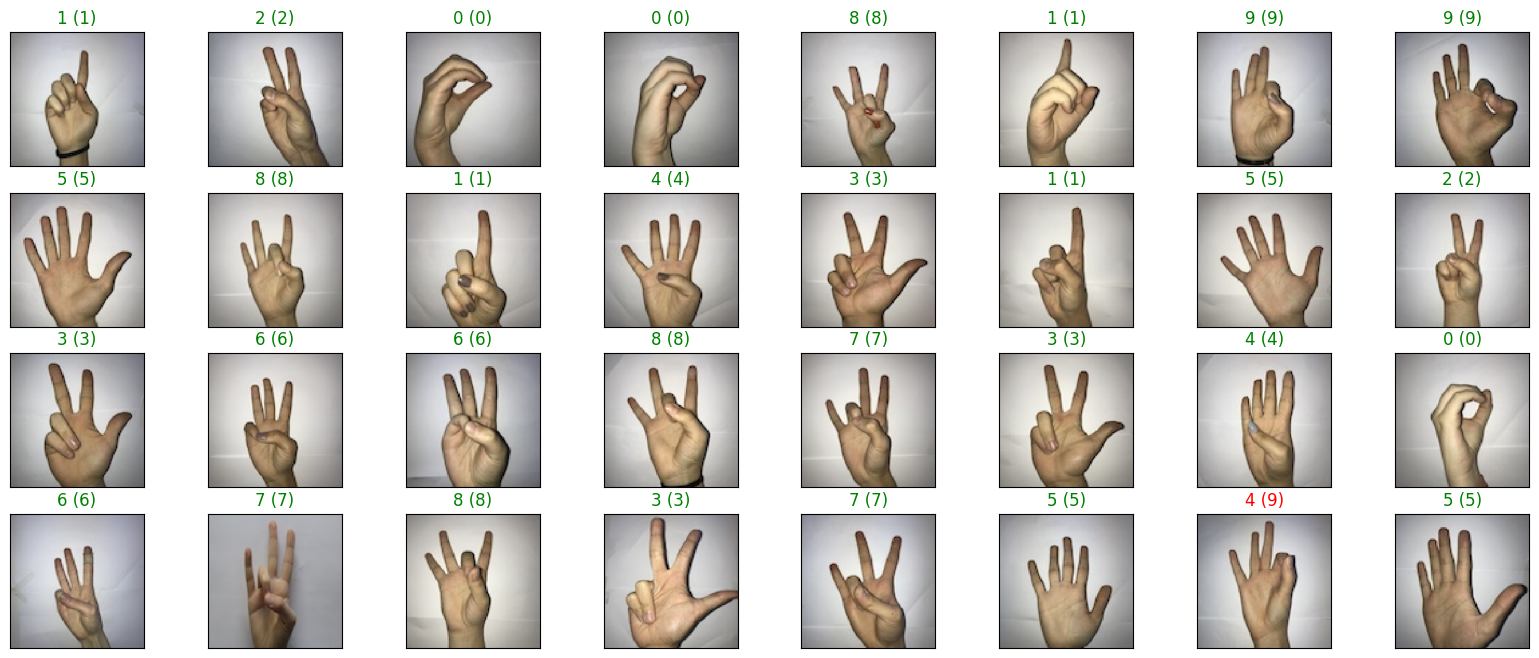

In [ ]:
num_test_images = test_batches.samples

# Plot 32 random test images with predictions vs ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(num_test_images, size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])

    # Load and display test image
    img_path = test_batches.filepaths[idx]
    img = load_img(img_path, target_size=(224, 224))
    ax.imshow(img)

    # Predicted vs true class index
    pred_idx = np.argmax(y_hat[idx])
    true_idx = test_batches.classes[idx]
    ax.set_title(
        f"{labels[pred_idx]} ({labels[true_idx]})",
        color=("green" if pred_idx == true_idx else "red"),
    )

📊 Confusion Matrix

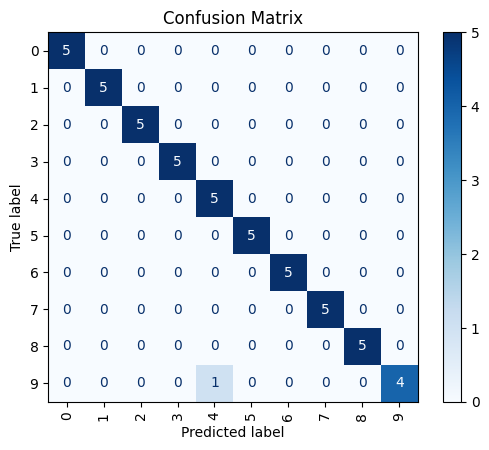

In [ ]:
# Get true and predicted labels
y_true = test_batches.classes
y_pred = np.argmax(y_hat, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()